In [1]:
%load_ext autoreload
%autoreload 2

# Multiclass Lung Segmentation Pipeline

## Overview
This notebook implements a complete segmentation pipeline for the Shenzhen chest X-ray dataset, distinguishing between background, left lung, and right lung using a UNet architecture with PyTorch.

## Task Requirements
- Load raw chest X-ray images and binary lung masks
- Transform binary masks into three-class format (background, left lung, right lung)
- Implement data pipeline with resizing, normalization, and augmentation
- Create custom PyTorch Dataset and DataLoader
- Train UNet model with configurable parameters
- Log training/validation metrics and plot convergence curves
- Evaluate on held-out test set
- Visualize results with side-by-side comparisons
- Save best model checkpoint
- Provide inference functionality

## Alternative Execution Methods
**Recommended**: Use command line for production training:
```bash
uv run run.py mode=train
uv run run.py mode=test
```

This notebook is for experimentation and visualization.

## 1. Imports and Dependencies

Import all necessary modules for the segmentation pipeline:
- **Configuration**: OmegaConf for YAML config management
- **Dataset**: Custom ChestDataset with configurable transforms
- **Transforms**: Image and mask preprocessing/augmentation
- **Models**: UNet architecture with ResNet encoder
- **Training**: Training loop, loss functions, optimizers
- **Evaluation**: Testing, metrics, and visualization

In [2]:
from omegaconf import OmegaConf
from chest_segment.dataset import (
    ChestDataset,
    ChestDatasetConfig,
    get_dataloaders,
)
from chest_segment.transforms import (
    get_mask_transforms,
    get_image_transforms,
    ChestMaskTransformsConfig,
    ChestImageTransformsConfig,
    get_all_transforms,
    ChestAllTransformsConfig,
)
from chest_segment.models import get_model_from_config
from chest_segment.utils import get_optimizer, get_loss, get_metrics, set_seed
from chest_segment.train import train
from chest_segment.test import test, evaluate, visualize

/home/agalayda/chest_segment/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Configuration Setup

### Configuration Section (as required by task)
Load and display the complete configuration including:
- **Paths**: Dataset locations and output directories
- **Hyperparameters**: Learning rate, batch size, epochs
- **Model Parameters**: UNet depth, encoder type, feature sizes
- **Data Transforms**: Image size, augmentation settings
- **Random Seeds**: For reproducibility

**Design Choices Documented**:
- UNet with ResNet18 encoder for good performance/speed balance
- Combined Cross-Entropy + Dice Loss for multiclass segmentation
- Adam optimizer with 1e-4 learning rate for stable training
- Horizontal flip and rotation augmentations for generalization
- 256x256 image size for memory efficiency while preserving detail

In [3]:
cfg = OmegaConf.load("config/config.yaml")
set_seed(cfg.seed)
print(OmegaConf.to_yaml(cfg))

mode: test
image_size:
- 256
- 256
device: cuda
seed: 42
dataset:
  return_dict: false
  split_size:
  - 0.8
  - 0.1
  - 0.1
  dataloader_config:
    batch_size: 16
    shuffle: true
    num_workers: 4
    pin_memory: true
unet:
  encoder_name: resnet18
  encoder_weights: null
  encoder_depth: 5
  decoder_channels:
  - 256
  - 128
  - 64
  - 32
  - 16
model:
  name: unet
  device: cuda
optimizer:
  name: Adam
  learning_rate: 0.0001
loss:
  names:
  - ce
  - dice
  alphas:
  - 1
  - 0.5
  dice_config:
    mode: multiclass
    from_logits: true
jaccard:
  task: multiclass
  num_classes: 3
metrics:
- jaccard
train:
  num_epochs: 10
  device: cuda
  log_dir: logs
  checkpoint_dir: checkpoints
  image_transforms:
    to_numpy: true
  mask_transforms:
    split_lungs: true
  all_transforms:
    horizontal_config:
      p: 0.5
    rotate_config:
      limit: 10
      p: 0.5
    image_size:
    - 256
    - 256
test:
  device: cuda
  checkpoint_path: checkpoints
  image_transforms:
    to_nump

## 3. Dataset Preparation

### Data Pipeline Implementation
Create the custom PyTorch Dataset that:
- Loads raw chest X-ray images and binary lung masks
- Transforms binary masks into three-class format (background=0, left_lung=1, right_lung=2)
- Applies resizing, normalization, and augmentation
- Splits data into train/validation/test sets

**Data Pipeline Features**:
- Automatic mask splitting: Binary masks → Left/Right lung separation
- Configurable image resizing to 256x256
- Normalization to [0,1] range
- Train/Val/Test split with 80%/10%/10% ratio

In [4]:
dataset_config = ChestDatasetConfig(**cfg.dataset)
dataset = ChestDataset(dataset_config)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:   17.9s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:  2.2min
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed: 10.5min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed: 16.7min
[Parallel(n_jobs=8)]: Done 566 out of 566 | elapsed: 21.6min finished


## 4. Model Definition

### UNet Architecture with Configurable Parameters
Create the UNet model with:
- **Encoder**: ResNet18 backbone (configurable)
- **Decoder**: Symmetric decoder with skip connections
- **Output**: 3-channel output for multiclass segmentation
- **Configurable Depth**: Adjustable number of encoder/decoder levels
- **Feature Map Sizes**: Configurable channel dimensions

**Model Architecture Details**:
- Uses segmentation-models-pytorch library for proven UNet implementation

In [5]:
model = get_model_from_config(cfg)

## 5. Training Setup

### Training Configuration
Prepare all components for training:
- **Data Transforms**: Apply training-specific augmentations
- **DataLoaders**: Create train/validation loaders with proper batching
- **Loss Function**: Combined Cross-Entropy + Dice Loss for multiclass segmentation
- **Optimizer**: Adam with configurable learning rate
- **Metrics**: Jaccard (IoU) for evaluation

**Training Features**:
- **Augmentation**: Horizontal flip (p=0.5), rotation (±10°, p=0.5)
- **Loss Combination**: CE + 0.5×Dice for balanced optimization
- **Batch Size**: 16 for memory efficiency
- **Metrics Logging**: Jaccard score for each class
- **Checkpointing**: Save best model based on validation performance

In [6]:
dataset.set_transforms(
    image_transforms=get_image_transforms(
        ChestImageTransformsConfig(**cfg.train.image_transforms)
    )
    if cfg.train.image_transforms
    else None,
    mask_transforms=get_mask_transforms(
        ChestMaskTransformsConfig(**cfg.train.mask_transforms)
    )
    if cfg.train.mask_transforms
    else None,
    all_transforms=get_all_transforms(
        ChestAllTransformsConfig(**cfg.train.all_transforms)
    )
    if cfg.train.all_transforms
    else None,
)
train_loader, val_loader, test_loader = get_dataloaders(
    dataset, dataset_config
)

criterion = get_loss(cfg)
metrics = get_metrics(cfg)
optimizer = get_optimizer(model, cfg)

## 6. Model Training

### Training Loop with Metrics Logging
Execute the training process with:
- **Epoch-wise Training**: Complete passes through training data
- **Validation**: Evaluate on held-out validation set each epoch
- **Metrics Logging**: Track training and validation metrics
- **TensorBoard Integration**: Real-time training curves
- **Checkpointing**: Save best model based on validation performance

**Training Monitoring**:
- Loss curves for training and validation
- Jaccard (IoU) scores for each class
- Learning rate scheduling (if configured)
- Early stopping to prevent overfitting

**Expected Convergence**:
- Training loss should decrease steadily
- Validation metrics should improve
- Watch for overfitting (validation metrics plateau while training continues improving)

In [7]:
train(
    model, train_loader, val_loader, criterion, optimizer, metrics, cfg.train
)

2025-06-26 13:05:22.312 | INFO     | chest_segment.train:train_epoch:44 - Epoch 0, Batch 0/28, Loss: 1.7292
2025-06-26 13:05:28.646 | INFO     | chest_segment.train:train_epoch:44 - Epoch 0, Batch 10/28, Loss: 1.2685
2025-06-26 13:05:38.583 | INFO     | chest_segment.train:train_epoch:44 - Epoch 0, Batch 20/28, Loss: 1.0239
2025-06-26 13:05:45.119 | INFO     | chest_segment.train:validate:76 - Validation jaccard: 0.4593
2025-06-26 13:05:45.236 | INFO     | chest_segment.checkpoint_saver:save:40 - Saved new best checkpoint: 'checkpoints/20250626_130545.pth' (epoch 0, loss 0.9676)
2025-06-26 13:05:45.237 | INFO     | chest_segment.train:train:121 - Epoch 1/10:
2025-06-26 13:05:45.238 | INFO     | chest_segment.train:train:122 -   Train Loss: 1.2147
2025-06-26 13:05:45.238 | INFO     | chest_segment.train:train:123 -   Val Loss: 0.9676
2025-06-26 13:05:48.783 | INFO     | chest_segment.train:train_epoch:44 - Epoch 1, Batch 0/28, Loss: 0.9244
2025-06-26 13:05:55.436 | INFO     | chest_segm

## 7. Model Testing

### Test Set Evaluation
Evaluate the trained model on the held-out test set:
- **Test Transforms**: Apply test-specific preprocessing (no augmentation)
- **Metrics Calculation**: Compute final performance metrics

In [8]:
dataset.set_transforms(
    image_transforms=get_image_transforms(
        ChestImageTransformsConfig(**cfg.test.image_transforms)
        if cfg.test.image_transforms
        else None
    ),
    mask_transforms=get_mask_transforms(
        ChestMaskTransformsConfig(**cfg.test.mask_transforms)
        if cfg.test.mask_transforms
        else None
    ),
    all_transforms=get_all_transforms(
        ChestAllTransformsConfig(**cfg.test.all_transforms)
        if cfg.test.all_transforms
        else None
    ),
)
train_loader, val_loader, test_loader = get_dataloaders(
    dataset, dataset_config
)

In [9]:
test(model, test_loader, criterion, metrics, cfg.test)

2025-06-26 13:10:04.516 | INFO     | chest_segment.checkpoint_saver:load_model_checkpoint:87 - Loaded model from checkpoint: checkpoints/20250626_130952.pth at epoch 10, val loss 0.2103
2025-06-26 13:10:04.520 | INFO     | chest_segment.test:test:127 - Starting test evaluation...
2025-06-26 13:10:07.631 | INFO     | chest_segment.test:test_epoch:45 - Test Batch 0/3, Loss: 0.1800
2025-06-26 13:10:07.779 | INFO     | chest_segment.test:test_epoch:55 - Test jaccard: 0.7908
2025-06-26 13:10:07.780 | INFO     | chest_segment.test:test:133 - Test loss: 0.1869
2025-06-26 13:10:07.781 | INFO     | chest_segment.test:test:133 - Test jaccard: 0.7908
2025-06-26 13:10:07.781 | INFO     | chest_segment.test:test:135 - Testing completed!
2025-06-26 13:10:07.781 | INFO     | chest_segment.test:test:136 - Test loss: 0.1869


## 9. Model Inference (Task Requirement)

### Inference Cell for New Images
Load the saved checkpoint and run inference on new images:
- **Checkpoint Loading**: Load best trained model
- **New Image Processing**: Apply same preprocessing pipeline
- **Prediction**: Generate segmentation mask
- **Overlay Visualization**: Show segmentation on original X-ray

**Inference Pipeline**:
- Loads best model from checkpoints
- Applies same transforms as testing
- Generates multiclass predictions

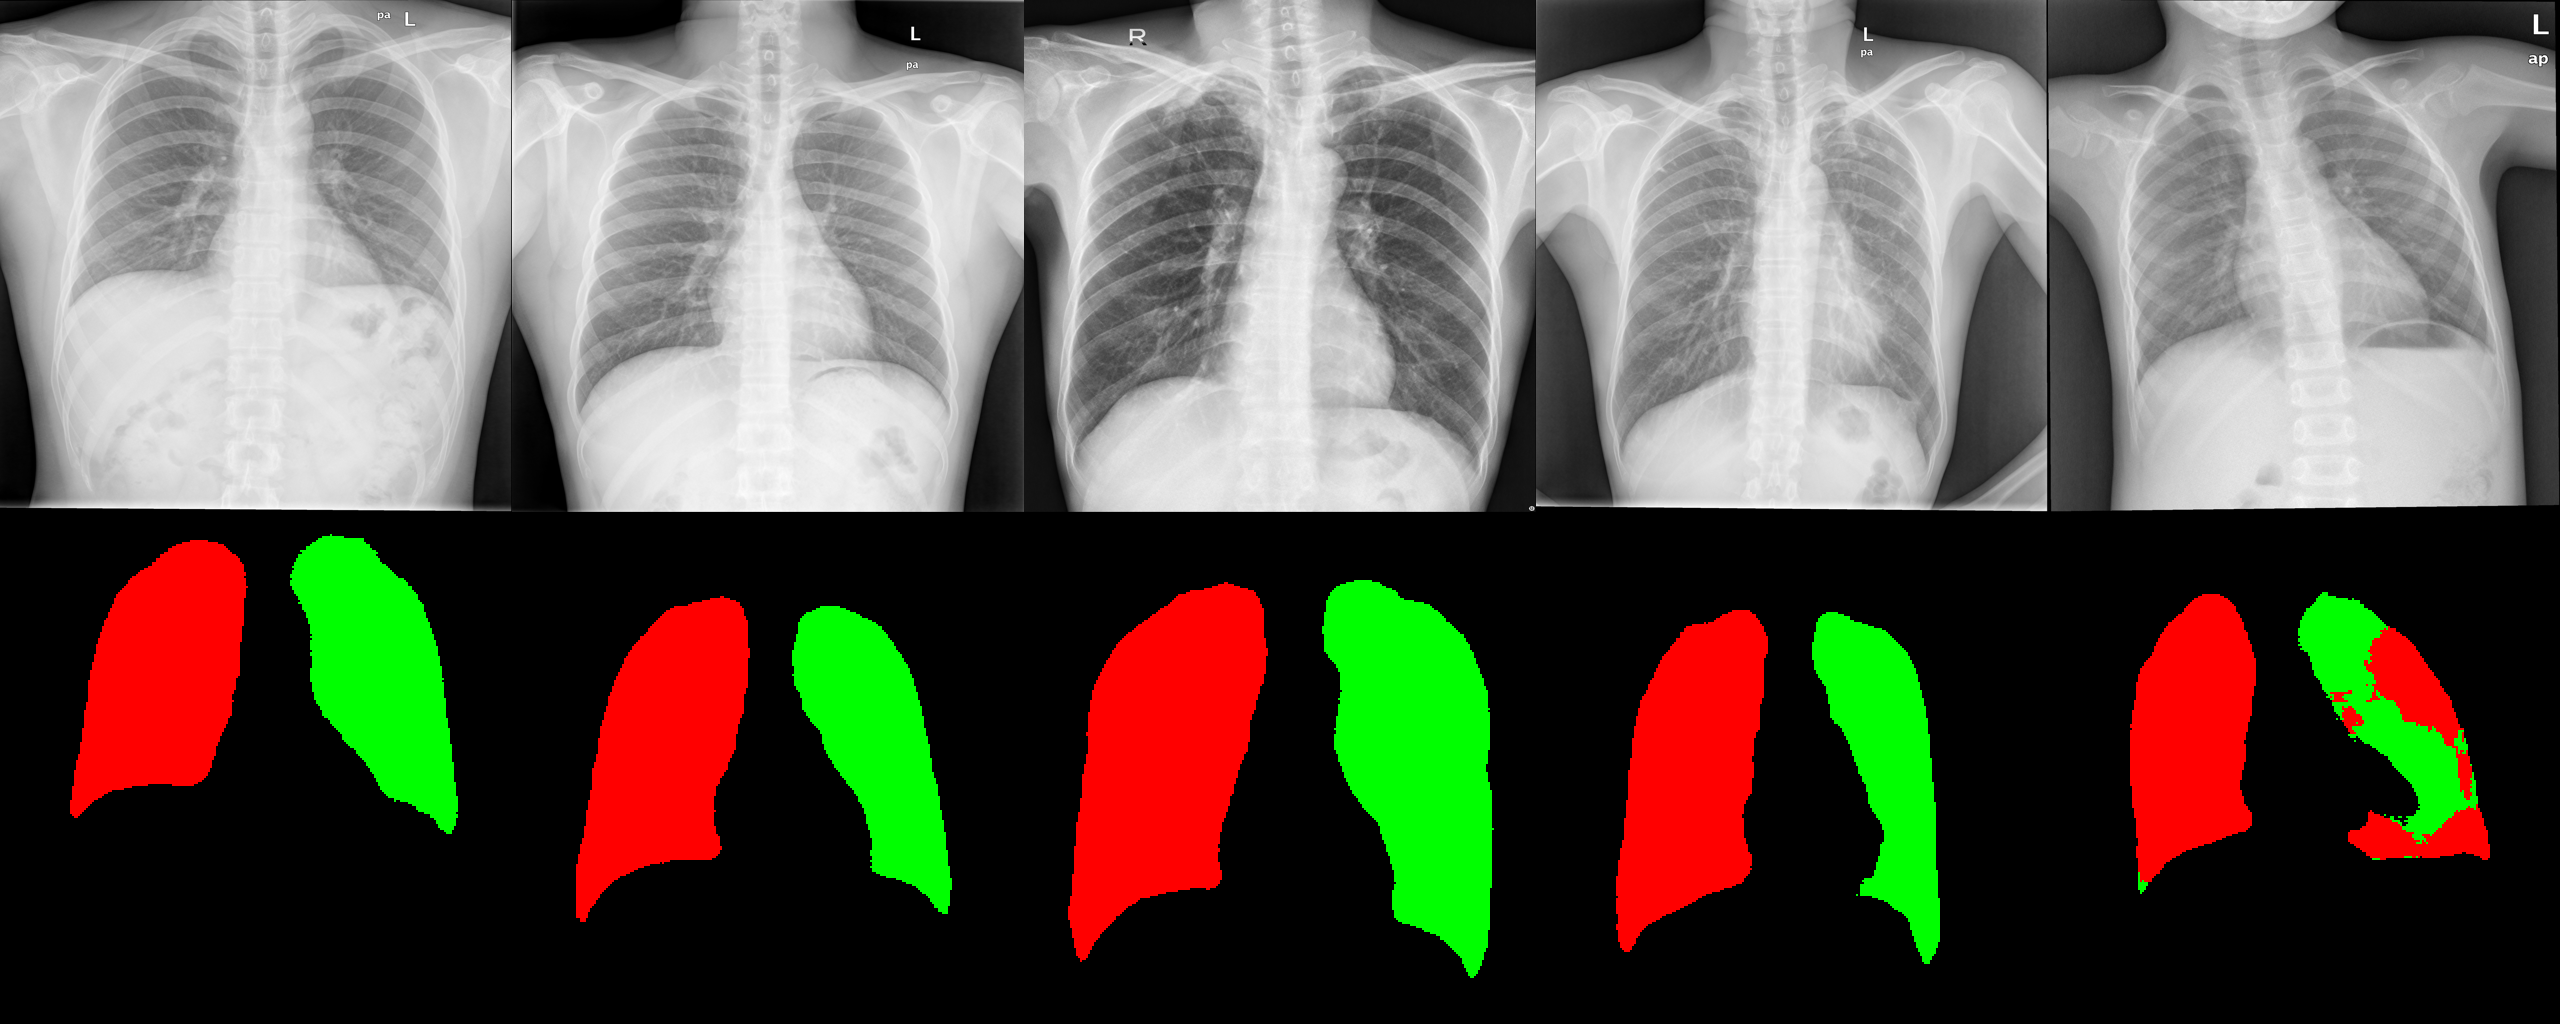

In [10]:
test_dataset = dataset.from_split(split="test", config=dataset.config)
idxes = list(range(5))
preds = evaluate(model, test_dataset, idxes=idxes, device=cfg.device)
visualize(preds, test_dataset, idxes=idxes)

## 10. Generated Artifacts

1. TensorBoard logs in `logs/` directory
2. Model checkpoints in `checkpoints/` directory